# Methods for Data Science CW 3

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sbn
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_openml
from sklearn.utils.linear_assignment_ import linear_assignment
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import TensorDataset

torch.manual_seed(0)
np.random.seed(0)

# 1
In this task, we explore citations between academic papers, and try to classify papers by the words they contain. To do this, we first load the feature matrix (i.e. the papers, and the words they contain), and the adjacency matrix, where every positive entry means two papers cite each other (ignoring directionality).

In [4]:
feature_mat = np.loadtxt(open("Task1/feature_matrix.csv", "rb"), delimiter=",")
adj_mat = np.loadtxt(open("Task1/adjacency_matrix.csv", "rb"), delimiter=",")

In [5]:
print(f"The feature matrix is of dimensions: {(len(feature_mat), len(feature_mat[0]))}")
print(f"The adjacency matrix is of dimensions: {(len(adj_mat), len(adj_mat[0]))}")

The feature matrix is of dimensions: (2485, 1433)
The adjacency matrix is of dimensions: (2485, 2485)


As promised in the instructions, we find a feature matrix containing 2485 papers, each containing subsets of 1433 words. We also have a matching adjacency matrix of size 2485x2485. Both these matrices contain binary values.

## 1.1 Clustering of the feature matrix (15 marks)

To find an optimal number of clusters for this task, k, we will train a KMeans classifier with values from 2 to 30, noting the Calinski-Harabasz (CH) score for every classifier. 

The CH score takes a ratio of $\frac{\operatorname{between-cluster\ dispersion}}{\operatorname{inner-cluster\ dispersion}}$. We know the denominator will keep on decreasing as k increases because all points get closer to their respective centers. The larger the numerator, the larger the dispersion between clusters. This indicates that a high CH score means that clusters are very well separated and dense.

In our case, we're looking for a balance. We want sufficiently many clusters to describe a broad range of topics (i.e. groupings of papers) but we also want the groupings to be accurate. We also want to avoid overfitting (for k = size of dataset, every datapoint gets its own cluster). As such, we're told to pick the first value of k with a CH score below 7 as our optimal number of clusters. 

To deal with the inherent randomness of k-means optimisation, we trial every k value every time to get an average CH score. This helps mitigate the variance of our results. Below, find a graph of the CH scores for the different values of k.

In [6]:
X = feature_mat

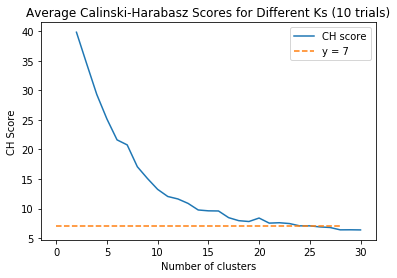

In [7]:
avg_chs = []
optimal = 0

for i in range(2, 31):
    chs = []
    for trial in range(10):
        kmeans = KMeans(n_clusters=i, n_jobs=-1)
        kmeans.fit(X)
        labels = kmeans.labels_
        ch = metrics.calinski_harabasz_score(X, labels)
        chs.append(ch)
    avg = np.mean(chs)
    avg_chs.append(avg)
    if optimal == 0 and avg < 7:
        optimal = i
        
plt.plot(range(2, 31), avg_chs, label="CH score")
plt.title('Average Calinski-Harabasz Scores for Different Ks (10 trials)')
plt.xlabel('Number of clusters')
plt.ylabel('CH Score')
plt.plot([7 for _ in range(2,31)], linestyle="dashed", label="y = 7")
plt.legend()
plt.show()

In [8]:
optimal_kmeans = KMeans(n_clusters=optimal)
optimal_kmeans.fit(X)
print(f"The first k with a CH score under 7 is {optimal}")

The first k with a CH score under 7 is 26


As seen on the plot above, the yellow, dotted line ($y=7$) intersects the blue line around 25. The optimal value is confirmed to be 26 just under the graph. 

Below, we'll look at the distribution of cluster sizes:

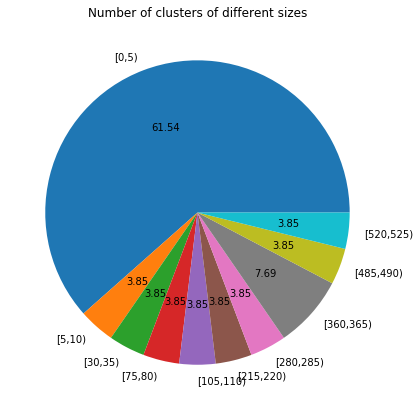

In [9]:
def cluster_sizes(model):
    labels = model.labels_
    sizes = {}
    for c in set(labels):
        sizes[c] = (labels == c).sum()
    return sizes

sizes = cluster_sizes(optimal_kmeans)
buckets = {}
for i in range(0,1000,5):
    tot = 0
    for v in sizes.values():
        tot += 1 if i <= v < i+5 else 0
    if tot > 0:
        buckets[i] = tot
        
plt.figure(figsize=(7, 7))
plt.pie(buckets.values(), labels=[f"[{b},{b+5})" for b in buckets.keys()],autopct='%.2f')
plt.title("Number of clusters of different sizes")
plt.show()

We find that most clusters are very small. 61% of clusters contain between 0 and 5 points only. We notice that the biggest cluster englobes over 500 points. This is a really unbalanced distribution of size and might suggest that our research papers contain a few really popular fields, as more smaller and less popular fields of study. The latter are the ones that have small clusters.

Next, we will look at some metrics to analyse our model:

In [10]:
silhouette_score = metrics.silhouette_score(X, optimal_kmeans.labels_)
davies_bouldin = metrics.davies_bouldin_score(X, optimal_kmeans.labels_)
print(f"The silhouette score for this model: {silhouette_score}")
print(f"The davies-bouldin index for this model: {davies_bouldin}")


The silhouette score for this model: -0.02457558282241621
The davies-bouldin index for this model: 3.0075508564596842


Here, we output a Silhouette score, and a Davies-Bouldin (DB) index for the model.

The DB index looks at the average 'similarity' between clusters. When talking about similar clusters i, and j, we compare the distance between them, and their sizes, s (average distances from points in a cluster to the center):$R_{i,j}= \frac{s_i+s_j}{d_{i,j}}$. 

A model with well-separated clusters will thus have a low DB index, 0 being the lowest possible score. A value of 3 means that we have points that will be within the range of other clusters and that they aren't as disjoint as we woud like.

The best silhouette score value is 1 and the worst value is -1, values near 0 indicating overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

The silhouette score takes into account two metrics: 

(a), the mean distance between a point, and all the others in the samen cluster.

(b), the average distance between a point and all the points in the nearest neighboring cluster.
$$ S = \frac{b-a}{max(b,a)} $$

Visibly, a score near 0 means that distance between a point and its neighbors is nearly equal to the distance to the points in its cluster, implying overlap.

The silhouette, DB, and CH scores all agree that our clusters aren't very separated.

## 1.2 Analysis of the citation graph (10 marks)

In this section, we analyze the citation graph, and try to discover some properties of it. Ultimately, the goal is to compare the clusterings found above to the citation graph, finding similarities and/or differences.

We'll start by drawing the graph.

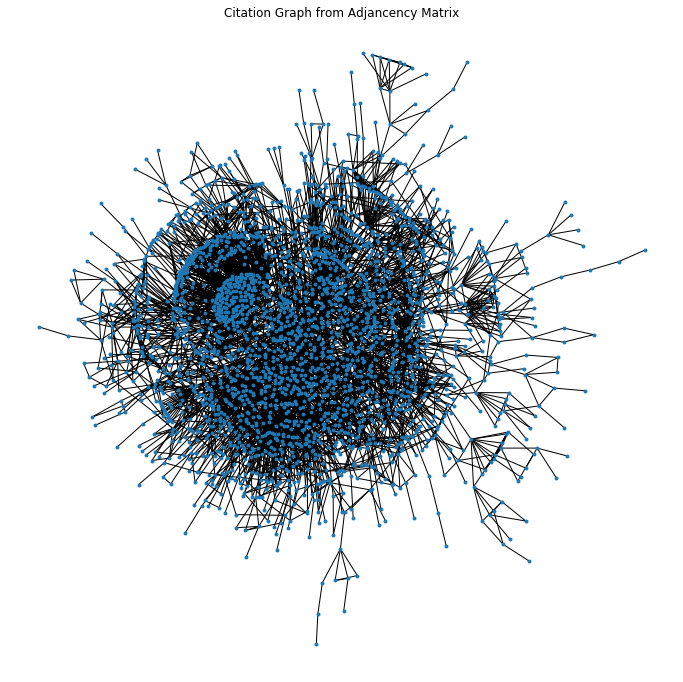

In [11]:
G = nx.from_numpy_matrix(adj_mat)

plt.figure(figsize=(12,12)) 
plt.title("Citation Graph from Adjancency Matrix")
nx.draw_kamada_kawai(G,node_size=15, with_labels=False, linewidths=0.05)
plt.show()

Drawn with the Kamada-Kawai method, we see that the graph has a very dense and interconnected center. As we extend away from the center, we see that a few of the nodes (papers) have sparser connections, often connected in chains.

Because it's such a massive graph, it's very hard to get an accurate impression. As such, we'll try to get more information out of it, starting with the distribution of the nodes' degrees:

The max degree in the graph is: 168


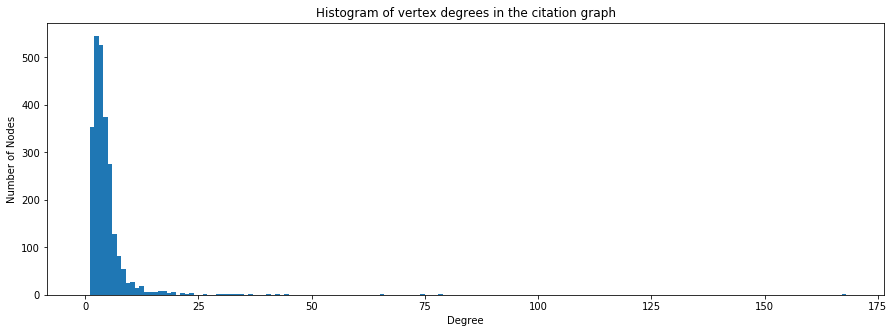

In [12]:
degrees = G.degree()

degrees_val = [d for (v,d) in degrees]
print(f"The max degree in the graph is: {max(degrees_val)}")
plt.figure(figsize=(15,5)) 
plt.title("Histogram of vertex degrees in the citation graph")
plt.hist(degrees_val, range(0, max(degrees_val)+1))
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

As seen on the histogram above, nearly all our nodes have degrees below 25, most of which are in the single digits. The highest degree is a node with 168 neighbours. We'll look at the most central nodes (in terms of degree) later.

Below, we'll compute three measures of node centrality:

1. The nodes' degrees is a measure of centrality because the more citations, the more important the paper.

2. The nodes' betweenness-centrality which is the sum of the fractions of shortest paths between all pair of nodes that go through a node. In other words, it measures to what extent a node is on the paths between all other nodes. It ranges from 0 to 1, 0 being completely out of the way and 1 being very 'central' (i.e. on every shortest path between pairs).
$$\displaystyle{b_i = \sum_{s, t} \frac{n_{s,t}^{i}}{n_{s,t}}}$$
Where $n_{s,t}$ is the number of shortest paths from s to t and $n_{s,t}^{i}$ is the amount of those that pass through node i. It's worth noting that in undirected graphs, the shortest paths from s to t and t to s will be the same ones so essentially they'll all be counted twice, doubling the value of $b_i$ but it doesn't matter too much since we're more concerned about relative magnitudes. 

3. The nodes' pagerank. Pagerank is an algorithm developed by Google to measure the importance of websites. It outputs a probability distribution representing the likelihood that a random walk will lead to any particular node. Since it's a probability distribution, it follows all the standard rules like the sum of all pageranks equals 1, all values are positive, and smaller or equal to 1. A pagerank of 1 implies any citation leads to a node, while a pagerank of 0 means nothing has ever cited the node.

In [13]:
degrees = G.degree()
b_centrs = nx.betweenness_centrality(G)
pageranks = nx.pagerank(G)

In [14]:
measures = pd.DataFrame(degrees, columns=['node', 'degree'])
measures['between_centr']= measures['node'].map(b_centrs)
measures['pagerank']= measures['node'].map(pageranks)
measures.head()

,node,degree,between_centr,pagerank
0,0,3,0.000001,0.000366
1,1,3,0.001283,0.000420
2,2,5,0.004811,0.000561
3,3,5,0.000655,0.000432
4,4,3,0.000009,0.000367


Above, we've created a dataframe that collects these measures. The task is now to find nodes that are highly central according to the three measures. To take all three measures into account, we take the average of the normalized values. We have to normalize them because they have very different ranges. For example, degrees go from 1 to 168 whereas betweenness-centrality and pageranks are all small values below 1.

Below, we normalize, average, and output the top 5 nodes according to the average of the normalized measures.

In [15]:
def normalize(df, col):
    max_value = df[col].max()
    min_value = df[col].min()
    df[f"norm_{col}"] = (df[col] - min_value) / (max_value - min_value)
    return df

measures = normalize(measures, 'degree')
measures = normalize(measures, 'between_centr')
measures = normalize(measures, 'pagerank')
norms = measures[['norm_degree', 'norm_between_centr', 'norm_pagerank']]
measures['avg'] = norms.mean(axis=1)

top30 = measures.sort_values('avg', ascending=False).iloc[:30]
top30.head()

,node,degree,between_centr,pagerank,norm_degree,norm_between_centr,norm_pagerank,avg
1245,1245,168,0.276114,0.013302,1.000000,1.000000,1.000000,1.000000
1846,1846,65,0.149763,0.005833,0.383234,0.542397,0.433407,0.453012
1563,1563,74,0.101355,0.006811,0.437126,0.367076,0.507653,0.437285
271,271,78,0.090707,0.005511,0.461078,0.328511,0.409041,0.399543
1894,1894,40,0.106109,0.003471,0.233533,0.384295,0.254266,0.290698


We find that the most central node, without question is "node 1245". It's got the highest degree, pagerank, and betweenness and are therefore all normalized to 1. This node is incredibly central with regards to every individual measure as well. It more than doubles the degree, pagerank, and betweenness of the other central nodes.

We then get slightly different orders. For example, the second-most central node (1846) doesn't have the second-highest degree but has a relatively high betweenness-centrality. This could imply the node is "well placed" and that it has very central neighbors.

To go a bit more in depth, we'll look at the correlations between these measures:

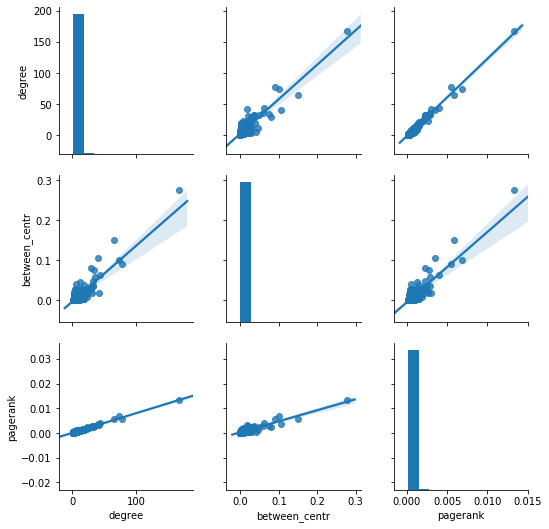

In [16]:
g = sbn.pairplot(measures[['degree', 'between_centr', 'pagerank']], kind='reg')

In [17]:
measures[['degree', 'between_centr', 'pagerank']].corr()

,degree,between_centr,pagerank
degree,1.000000,0.876926,0.988432
between_centr,0.876926,1.000000,0.884791
pagerank,0.988432,0.884791,1.000000


Above, we see the correlation between the measures both visually and quantitatively, finding that all the measures are very correlated. 

Nevertheless, they don't all exactly measure the same things. For example, pagerank will definitely be correlated to degree because more neighbours mean more citations, which increases the chances a random citation from the graph will belong to it but pagerank also takes into account the rank of the neighbour. 

Imagine a graph (left) where node A is connected to many nodes but these neighbours only have one other neighbour. Compare that to a situation where A has only one neighbour, but this one is very central, with a lot of neighbours (right). Imagine the big node is node 1245:
<img src="pagerank.png" alt="Drawing" style="width: 400px;"/>

Even though right A has fewer neighbour than left A, it will probably have a higher pagerank because the one citation is deemed "more important" according to pagerank.

Similarly, consider a node of the following form: 
<img src="bridge.png" alt="Drawing" style="width: 300px;"/>

In this case, node A is the only link between two sets of nodes (where connections in between these sets have been ommitted for clarity). A has a degree of 2 but it will have a very high betweenness-centrality since any path from one set to the other must pass through A.

The conclusion we're arriving at is that degree is a very simple indicator of centrality but it is crude in the sense that it doesn't take the shape of the graph into account at all. Pagerank and betweenness-centrality make an effort to acknowledge the dynamics of the graph. 

Having said that, degree is still a useful metric to measure centrality as it is computationally cheap, and although crude, is very correlated to the others we've seen. 

In terms of research papers and citations, high degrees mean many citations but they could all be from inconsequential papers (i.e. the papers on the outer rim of the graph drawn above) so the paper is not necessarily an important one. However, high betweenness-centrality could imply that the paper was instrumental in the advancement of a field of study, and generated many papers following up on it. Similarly, pageranks could be seen as a better version of degree since it not only takes into account the degree, but also the importance of the neighbours, making it clearer how important the paper is.

## 1.3 Community detection on the citation graph (10 marks)
The Clauset-Newman-Moore (CNM) modularity maximisation algorithm is a greedy algorithm that partitions the nodes of a graph into the optimal number of communities. It does this by finding partitions in which there are many edges between nodes inside a community, but few going outside of the community. This is defined as modularity.Essentially, it is comparing how much better a chosen partition is than a completely random one.

Starting with every node in its own community, this algorithm iteratively joins together the two communities that produce the largest increase in modularity. It does so until any additional merge results in a negative modularity score.

In [18]:
communities = nx.algorithms.community.greedy_modularity_communities(G)

In [19]:
print(f"The optimal value of k, k*, is {len(communities)}")

The optimal value of k, k*, is 29


It turns out that once we wittle the number of communities to 29, any additional split is detrimental to the modularity. We're now going to plot the graph with nodes of different colors representing their communities.

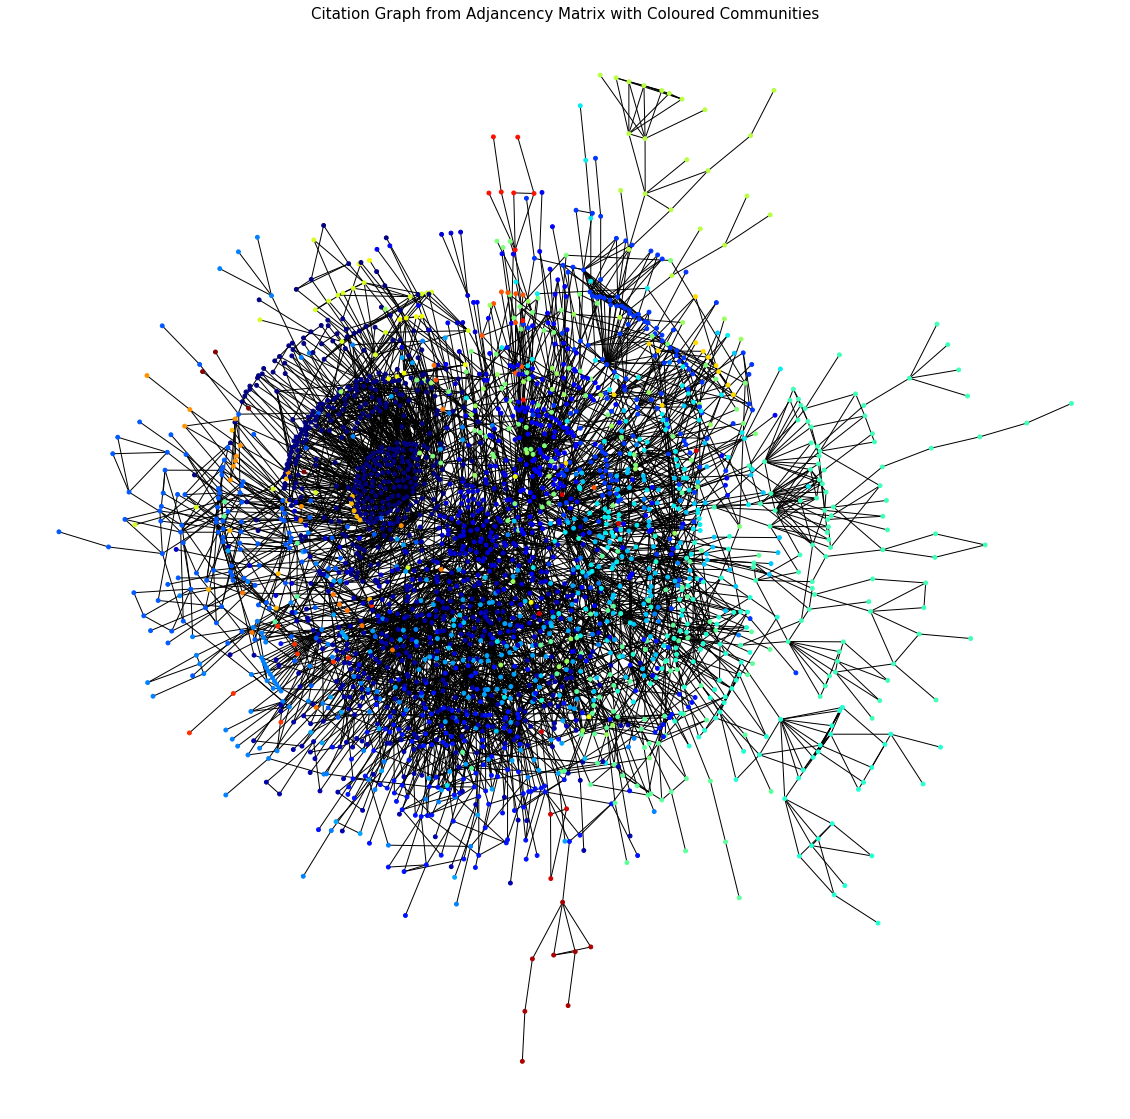

In [20]:
values = [0]* len(G.nodes())
for num, comm in enumerate(communities):
    for node in comm:
        values[node] = num

plt.figure(figsize=(20,20)) 
plt.title("Citation Graph from Adjancency Matrix with Coloured Communities", size=15)
cmap = plt.get_cmap('jet')
nx.draw_kamada_kawai(G, cmap=cmap, node_color=values, node_size=15,
                     with_labels=False)
plt.show()

From the graph above we can immediately spot a few things. First of all, We've got some very dense dark blue communities near the center of the graph. These seem to extend outwards from the center towards the edges. We also notice that the small branches of the graph towards the outer edge are well split. For instance, on the bottom right there is a big turquoise community jutting out of the dense graph. This seems to agree with the general description of the algorithm: many edges inside the community, and few coming out. Another example of that is the brown community at the very bottom of the graph.

We're now going to see how the most central nodes are distributed within these 29 communities. We'll look at the most central nodes in term of degree, pagerank, and we'll add the top 30 nodes in terms of combined measures as we constructed it in 1.2.

In [21]:
comm_measures = measures
comm_measures['community'] = values

top30['community'] = [values[x] for x in top30['node']]

max_degrees = comm_measures.sort_values('degree', ascending=False)[['degree', 'community']][:30]
max_pagerank = comm_measures.sort_values('pagerank', ascending=False)[['pagerank', 'community']][:30]

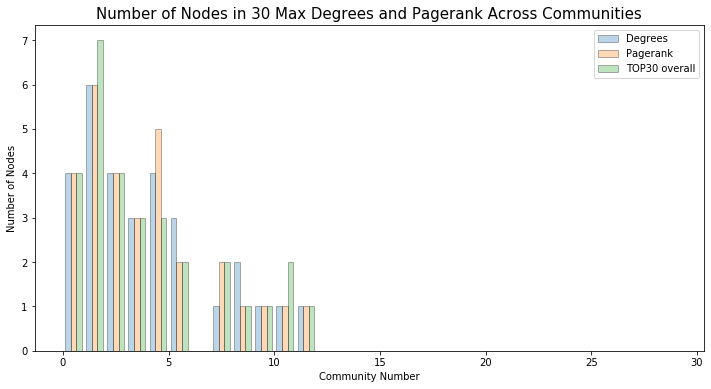

In [22]:
bins = range(0,30)
plt.figure(figsize=(12,6)) 
plt.title("Number of Nodes in 30 Max Degrees and Pagerank Across Communities", size=15)
plt.hist([max_degrees['community'], max_pagerank['community'], top30['community']], bins, 
         alpha=0.3, label=['Degrees', 'Pagerank', 'TOP30 overall'], edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Community Number')
plt.ylabel('Number of Nodes')
plt.show()

Because degrees and pageranks were very correlated, most of the 30 most central nodes according to those measures are probably the same ones so it makes sense that the blue and orange bars are very similar. We've got a bit more differences with the top30 overall bar but they're still relatively close.

What's interesting to see is that all the top 30 elements are within the first 12 communities. To try and explain that, we're going to look at the sizes of the communities.

Text(0, 0.5, 'Size of Community')

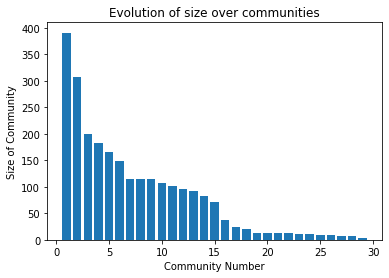

In [23]:
sizes = [len(comm) for comm in communities]

plt.bar(range(1,30),sizes)
plt.title("Evolution of size over communities")
plt.xlabel("Community Number")
plt.ylabel("Size of Community")

Interestingly, we see that the community sizes are decreasing. This explains the distribution of most central nodes because following the idea of "many edges inside the community, few outside", nodes with high degrees and pageranks are likely to be assigned to the same communities as their neighbours, and they've got many of those, leading to large communities. 

## 1.4 Compare feature and graph clusterings (10 marks)
Use Adjusted Mutual Information (AMI) and Adjusted Rand Index (ARI) to score how similar the optimal clusterings obtained in 1.1 and 1.3 are to each other.

Plot the clusters you obtained in 1.1 onto the NetworkX graph you generated in 1.2 so that you can compare visually the feature clusters in 1.1 to the graph-based communities in 1.3.

Based on the above, discuss the similarities and differences you observe. You can use other metrics or other visualisation methods to compare the two optimal clusterings at your discretion, explaining your choices.

In [24]:
greedy_community_labels = values
optimal_kmeans_labels = optimal_kmeans.labels_

AMI = metrics.adjusted_mutual_info_score(optimal_kmeans_labels, greedy_community_labels)
print(f"The AMI for the optimal KMeans and the Greedy Modularity Maximisation is {AMI}")

ARI = metrics.adjusted_rand_score(optimal_kmeans_labels, greedy_community_labels)
print(f"The ARI for the optimal KMeans and the Greedy Modularity Maximisation is {ARI}")

The AMI for the optimal KMeans and the Greedy Modularity Maximisation is 0.14529086433268382
The ARI for the optimal KMeans and the Greedy Modularity Maximisation is 0.08040060325273823


Adjusted Mutual Information (AMI) is a measure of the similarity between two clusterings. A perfect match will get a score of 1, and a random assignment will get a score near 0. Anything worse than random will go negative. The AMI is calculated by taking the joint entropy of the two clusterings, and then adjusted for chance. The adjustment is needed because the higher the amount of clusters, the higher the score tends to go. To remediate that, the MI is divided by the expected value of the score.

In our case, we get a score of around 0.15. This means the clusterings match better than with a random assignment but it's not great either. 

Next, we look at the Adjusted Random Index (ARI). Similarly to AMI, it calculates similarity. Again, a perfect match scores a 1, 0 is random, anything negative is worse than random, -1 being the worse possible score. ARI works by iterating over all the possible pairs and counting the ones that are in the same cluster in both clusterings, as well as those that are in different cluster in both clusterings. For example, for clustering $C$ and clustering $K$, and nodes $x$,$y$, increment the tally if $x$,$y$ are in the same cluster of $C$, $C_i$, and in the same cluster of $K$, $K_j$ or if they're under different labels in both $C$ and $K$. This score is then similarly adjusted.

Once again, our two clusters aren't very similar, scoring 0.08. It's better than random, but not by much. 

Below, we'll graph both to compare them.

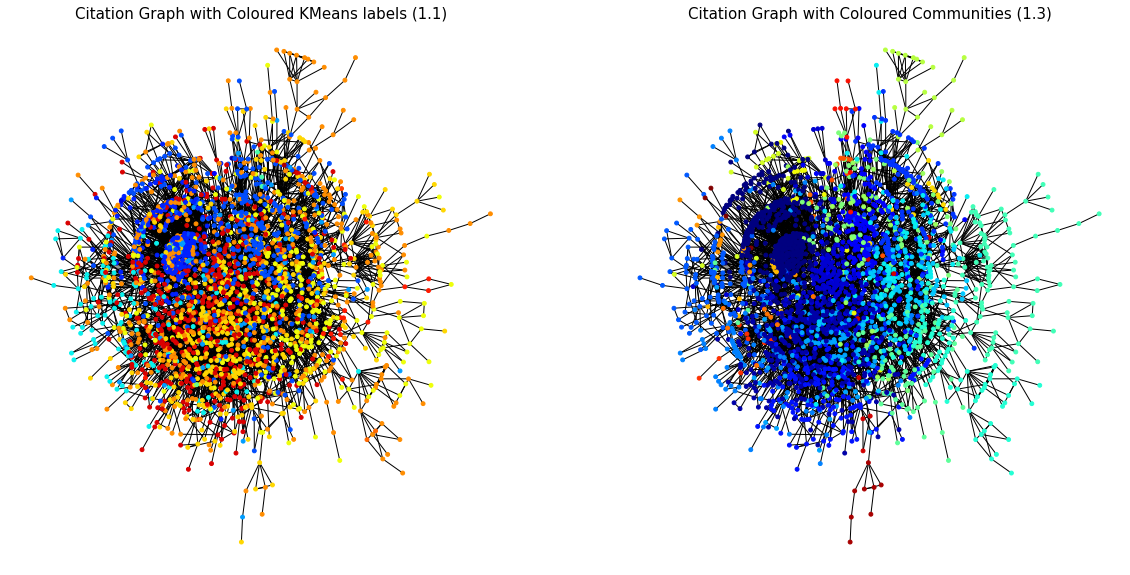

In [25]:
fig, axs = plt.subplots(figsize=(20,10), ncols=2, nrows=1) 
cmap = plt.get_cmap('jet')

axs.flat[0].set_title("Citation Graph with Coloured KMeans labels (1.1)", size=15)
nx.draw_kamada_kawai(G, cmap=cmap, node_color=optimal_kmeans_labels, node_size=15,
                     with_labels=False, ax=axs.flat[0])

axs.flat[1].set_title("Citation Graph with Coloured Communities (1.3)", size=15)
nx.draw_kamada_kawai(G, cmap=cmap, node_color=values, node_size=15,
                     with_labels=False, ax=axs.flat[1])

plt.show()

This is the graph of the KMeans clusterings. What we notice here is that the clusters aren't as dense as they were on the Greedy Modularity Community graph. The most obvious example of that is the yellow cluster. It appears all across the graph, from the center to the extremities of branches. The only label we find densely packed is the blue one near the center.

Here's the Communities graph again for ease of access. I mentioned it above, but here all the communities are densely packed compared to the KMeans clustering. Compared to the Community graph, the KMeans one doesn't seem to make much sense.

We'll compare the sizes of the clusters in the two graphs:

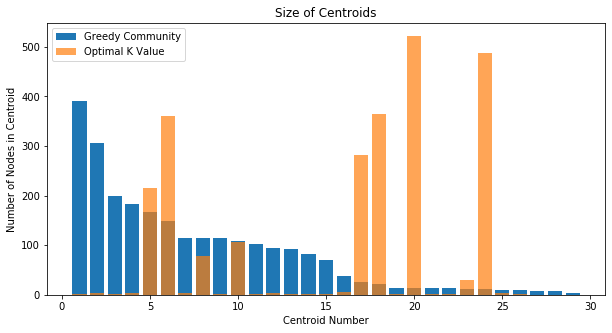

In [26]:
comm_sizes = [len(x) for x in communities]
optimal_kmeans_labels = list(optimal_kmeans_labels)
optimal_k_sizes = [optimal_kmeans_labels.count(c) for c in range(optimal)]

plt.figure(figsize=(10,5))
plt.title("Size of Centroids")
plt.bar(range(1,len(comm_sizes)+1), comm_sizes, label="Greedy Community")
plt.bar(range(1,len(optimal_k_sizes)+1), optimal_k_sizes, alpha=0.7,
       label="Optimal K Value")
plt.xlabel("Centroid Number")
plt.ylabel("Number of Nodes in Centroid")
plt.legend()
plt.show()


The blue bars were as seen in 1.3 and the orange bars represent the sizes of the KMeans cluster sizes. Obviously, the cluster numbers don't necessarily match but what we do observe is that the KMeans clusters are either very big, or very small. On the other hand, the Greedy Modularity algorithm has a more balanced distribution. 

## 2.1 Unsupervised clustering of the image dataset (20 marks)


In this exercise, we try to use k-means to cluster the MNIST fashion dataset. It contains 10 categories of clothes and our task is to group them together. First, we load the data, and split it into a training and testing set. We'll then have a look at out data, and see if kmeans is able to group them successfully.

In [27]:
mnist = fetch_openml('Fashion-MNIST', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)
print(f"Dimensions of the training set: {len(X_train), len(X_train[0])}")

labels = {0:"T-shirt/top", 1:"Trousers", 2:"Pullover", 3:"Dress", 4:"Coat", 
          5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boots"}

Dimensions of the training set: (60000, 784)


To get an idea of what we're working with, let's visualize what a few of these images look like:

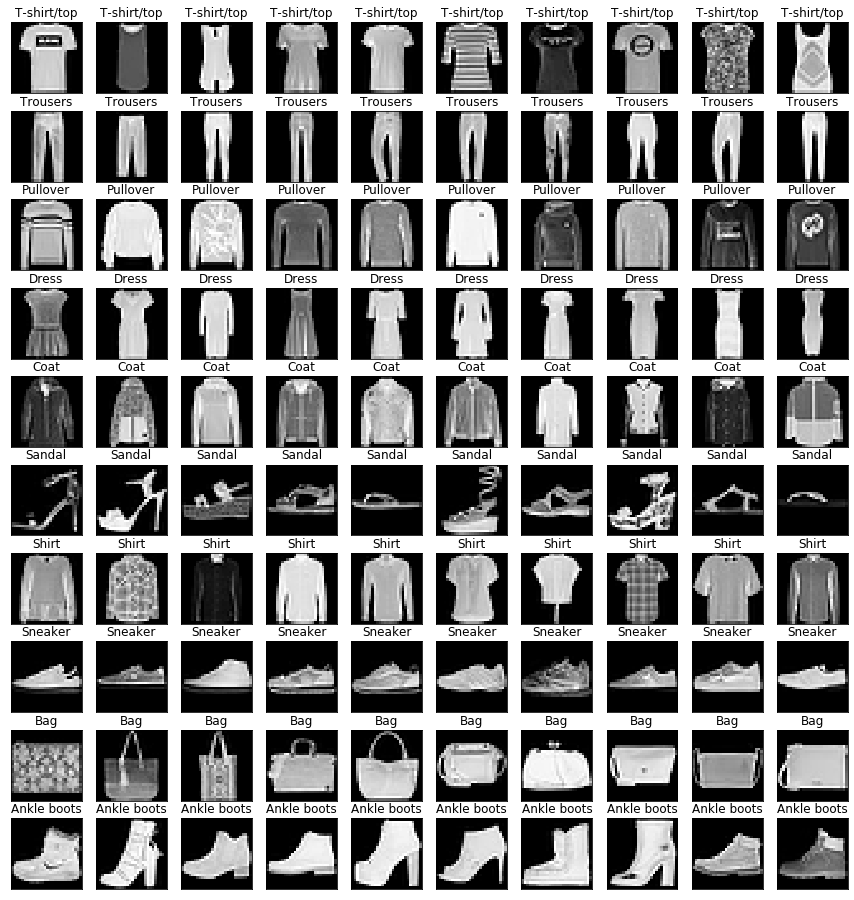

In [29]:
plt.figure(figsize=(15,16))
df = pd.DataFrame(X)
df['label'] = y

for label in range(10):
    objs = df[df['label'] == label]
    for i in range(10):
        plt.subplot(10, 10, label*10+i+1)
        fig = plt.imshow(np.array(objs.iloc[i])[:-1].reshape(28, 28), cmap = plt.cm.gray)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.title(labels[label])

Now, similarly to what we did in task 1, we'll train kmean models with a variety of Ks ($[2,30]$) and see if we can find any evidence that the expected $k=10$ is the optimal number of clusters. We'll use the same strategy to deal with randomness we used in task 1 -that is we'll do repeated trials. We'll also get average DB scores and Silhoutte scores to see if we can get any additional information on the clusterings.

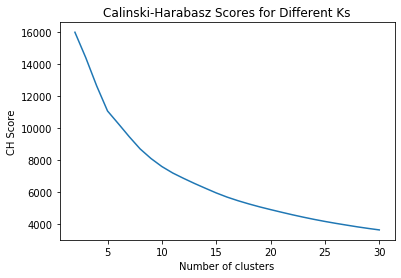

In [30]:
avg_f_chs = []
avg_bds = []
avg_sils= []

for i in range(2, 31):
    chs = []
    bds = []
    sils= []
    for trial in range(10):
        kmeans = KMeans(n_clusters=i, n_jobs=-1)
        kmeans.fit(X_train)
        labels = kmeans.labels_
        chs.append(metrics.calinski_harabasz_score(X_train, labels))
        bds.append(metrics.davies_bouldin_score(X_train, labels))
        sils.append(metrics.silhouette_score(X_train, labels))
    avg_f_chs.append(np.mean(chs))
    avg_bds.append(np.mean(bds))
    avg_sils.append(np.mean(sils))
        
plt.plot(range(2, 31), avg_f_chs)
plt.title('Calinski-Harabasz Scores for Different Ks')
plt.xlabel('Number of clusters')
plt.ylabel('CH Score')
plt.show()

Here, we find the CH score to be decreasing. Had there been a lot of evidence for $k=10$ as optimal, we would have seen a peak of the CH score at 10 because we would have clearly separate clusters for every type of clothes in the set. We'll look at the other metrics below:

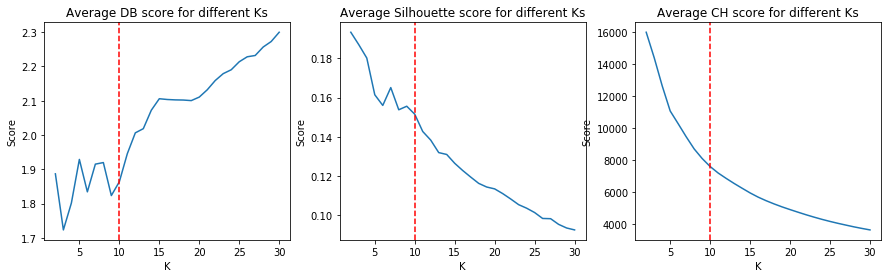

In [31]:
fig, axs = plt.subplots(figsize=(15,4), ncols=3, nrows=1)
xs = range(2,31)
for no, score, vals in [(0, "DB score", avg_bds), (1, "Silhouette score", avg_sils), (2, "CH score", avg_f_chs)]:
    axs.flat[no].plot(xs, vals)
    axs.flat[no].axvline(10, ls='--', color='r')
    axs.flat[no].set_xlabel("K")
    axs.flat[no].set_ylabel("Score")
    axs.flat[no].set_title(f"Average {score} for different Ks")

From left to right, the Davies Bouldin score isn't too bad. It stands just under 1.9 for $k=10$. What's interesting is varies highly for values less than 10. I attribute that to the fact that some of the 10 types of clothes we have look very similar and that with fewer clusters, some of them are grouped together. For example, taking a small k, it makes sense to group shirts, coats, and pullovers together as they have very similar shapes and few distinctive features with this granularity (28x28 pixels). This would in turn make the DB score quite good as the similar clusters are grouped together, and all the very different clusters are left.

The Silhouette score is also decreasing, with a few exceptions for small ks. This is possibly for the same reason I mentioned in the paragraph above.

None of these scores indicate that $k=10$ is optimal. Both the Silhouette score and the DB score have good values at lower ks and I believe these clusterings would most likely group together the shirt-like clothes together as they're the most 'similar' items in the set.

We're going to do more analysis on our $k=10$ clustering. So, we fit it again:

In [32]:
k10 = KMeans(n_clusters=10, n_jobs=-1)
k10.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

$k=10$ means we have ten centroids that datapoints match to. These centroids have coordinates and we can therefore see what they look most like. Below, we visualize what the ten centerpoints look like:

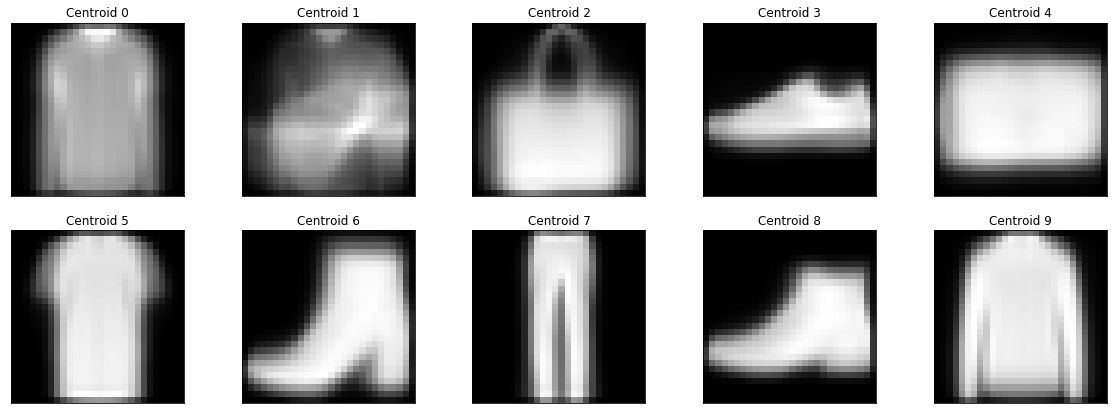

In [33]:
plt.figure(figsize=(20,7))
plt.title("Visualisation of the centroids for our k=10 kNN classifier")
for i in range(10):
    plt.subplot(2, 5, i+1);
    plt.title(f"Centroid {i}")
    fig = plt.imshow(k10.cluster_centers_[i].reshape(28, 28),
                  cmap = plt.cm.gray, interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Looking at the ten centers, we can clearly find a few of our classes: the bag is unmistakable (2), we've also got sneakers (3), ankle boots (8), pants (7), and tshirts (5).

Nevertheless, there is also some visible confusion. For example, Centroid 1 looks like a morph between a shirt-type thing with long sleeves, and a type of shoe. We also see that Centroid 4 must be a bag as well, meaning we've got 2 centroids for bags. Centroids 6 and 8 also both seem to represent boots. Furthermore, we can't spot any dresses at all.

I believe the problem is that we've got multiple labels that look very similar (i.e. long sleeved shirt-like clothes) and then we've got bags. There are 2 distinctive types of bags: with handle visible above the bag, and without. I suspect that the long sleeved tops have been mashed into Centroid 0, 1, and 9, and that the two types of bags got their own centroids.

This makes me think that the KMeans algorithm is more sensitive to the 'shape' of something rather than the actual pixel values.

Now that we've seen what our model looks like, we'll test its accuracy on the test set. Our only problem is that we don't actually know what label maps to what centroid and vice versa because the centroids are created in an unsupervised manner. To fix this, we've got to match every label to a cluster. To create the optimal mapping, we can just use a Hungarian Algorithm:

In [34]:
#Matching centroids to correct labels
#Hungarian Algorithm to solve optimal assignment problem
def cluster_assignment(y_true, y_pred):
    w = np.zeros((10, 10))
    for i in range(len(y_pred)):
        w[y_pred[i], y_true[i]] += 1
        
    assignment = linear_assignment(w.max() - w)
    return assignment

assignment = cluster_assignment(y_train, k10.labels_)
print("This is the optimal mapping between centroids and labels")
print("Centroid  Label")
for c in assignment:
    print(f"    {c[0]} ---> {c[1]}")

This is the optimal mapping between centroids and labels
Centroid  Label
    0 ---> 6
    1 ---> 5
    2 ---> 8
    3 ---> 7
    4 ---> 2
    5 ---> 0
    6 ---> 3
    7 ---> 1
    8 ---> 9
    9 ---> 4


We can now link the labels to their optimal clusters. So, we predict the testing clustering, and we convert it to the assigned labels.

In [35]:
#using k10 check accuracy and other metrics on test set
predicted = k10.predict(X_test)

predicted_labels = [assignment[pred][1] for pred in predicted]

Below, we'll draw our confusion matrix and extract a few other quality measures.

In [36]:
named_labels = [labels[x] for x in range(10)]

def draw_cm(preds, true_ys, xs=named_labels, ys=named_labels):
    plt.figure(figsize=(12,10))
    sbn.heatmap(confusion_matrix(preds, true_ys), annot = True, fmt='g', xticklabels=xs, yticklabels=ys)

    #Matplotlib bug causing a cutoff on top and bottom of heatmap rendition
    bottom, top = plt.ylim()
    plt.ylim(bottom + 0.5, top - 0.5)

    plt.show()

Confusion matrix for our kNN classifier


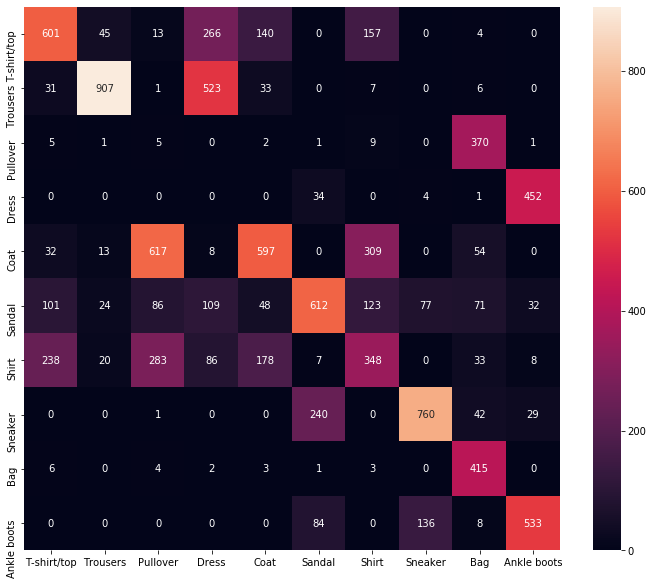

In [37]:
print("Confusion matrix for our kNN classifier") 
draw_cm(predicted_labels, y_test, xs=named_labels, ys=named_labels)

Unexpectedly, dresses are completely misclassified. Most of them are predicted to be ankle boots. The second missing class is the pullover. That one is mostly classified as a bag. This came as a suprise as I would have expected pullovers to be classified as coats, if anything.

Most of the other classes are relatively well assigned. Quite a lot of coats are classified as pullovers and shirts which makes sense due to their similar shapes. Similarly, the shirts are often matched as other types of shirt-like things (tshirts, pulloversm and coats).

The easily distinguishable shape of trousers is very well recognized.

Let's look at this intuitive description of the results more quantitatively, looking at accuracy, and other measures:

In [38]:
print(classification_report(predicted_labels, y_test))

              precision    recall  f1-score   support

           0       0.59      0.49      0.54      1226
           1       0.90      0.60      0.72      1508
           2       0.00      0.01      0.01       394
           3       0.00      0.00      0.00       491
           4       0.60      0.37      0.45      1630
           5       0.63      0.48      0.54      1283
           6       0.36      0.29      0.32      1201
           7       0.78      0.71      0.74      1072
           8       0.41      0.96      0.58       434
           9       0.51      0.70      0.59       761

    accuracy                           0.48     10000
   macro avg       0.48      0.46      0.45     10000
weighted avg       0.57      0.48      0.51     10000



Our model has an overall accuracy of 48%. Nevertheless, the results are a bit all over the place as we saw above. 2 of our classes have f1 scores that are basically 0, and the other vary between 0.32 and 0.74. We get an amazing 0.9 precision for the trousers label but its recall is low (0.6) indicating that a lot of things are mislabeled as trousers. On the other hand, bags aren't classified very precisely (0.41) but most bags are correctly identified, as shown by the 0.96 recall. 

## 2.2 Supervised classification of the training set (25 marks)
### 2.2.1 MLP neural network supervised classification: 
In this task, we train a multilayer perceptron (MLP) to classify the same images of clothes we worked with in the previous task, and we'll analyze it's performance.

First, since we're now working with neural nets, we need to standardise our data:

In [39]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled  = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

We can now create the tensors necessary for pytorch

In [40]:
train_tensor = TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train)) 
test_tensor = TensorDataset(torch.tensor(X_test_scaled), torch.tensor(y_test))

As told, here are our parameters:
* Hidden layers: 3
* Dimension of hidden layer: 100
* Activation function: ReLU
* Batch size: 128
* Learning rate: 0.005
* Number of epochs: 30

Obviously, our input and output dimensions will be the size of the images and the number of classes, respectively.

We first create our MLP class, and define the forward pass. Note that we are using a Softmax function on the output layer. This is because we're using negative log-likelihood loss and we need to output a probability vector.

In [41]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, f=F.relu):
        super(MLP, self).__init__()
        self.layer_in = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_out = nn.Linear(hidden_dim, output_dim)
        self.f = f

    def forward(self, x):
        out = self.f(self.layer_in(x))
        out = self.f(self.layer1(out))
        out = self.f(self.layer2(out))
        out = self.f(self.layer3(out))
        out = nn.LogSoftmax(dim=1)(self.layer_out(out))

        return out

Next, we create a function to train the network. We go through our training data 30 times (number of epochs), and calculate losses using negative log-likelihood with given learning rates, etc...

In [42]:
def train_network(network=MLP(input_dim= 28*28, hidden_dim = 100, output_dim=10, f=F.relu), 
                  batch_size = 128, learning_rate=0.005, num_epochs=30, graph=True,  train_tensor=train_tensor):

    #Prepare data
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size)
    
    criterion = nn.NLLLoss()
    optimiser = torch.optim.SGD(network.parameters(), lr=learning_rate)
    
    #Train net
    loss_values = []
    total_step = len(train_loader)

    for _ in range(num_epochs):

        network.train()
        train_loss = 0.0

        for Xs, ys in train_loader:
            
            # forward pass
            outputs = network(Xs)
            loss = criterion(outputs, ys)
            
            # backward and optimise
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            train_loss += loss.item()
        loss_values.append(train_loss / total_step)
    
    if graph:
        plt.figure(figsize=(12,8))
        plt.title('Training Loss over Epochs')
        plt.ylabel('Training Loss', fontsize=20)
        plt.xlabel('Epoch', fontsize=20)
        plt.plot(range(len(loss_values)), loss_values)
        plt.show()
     
    return network, loss_values

After training our MLP classifier, we plot the loss and get a nice curve that has the expected shape.

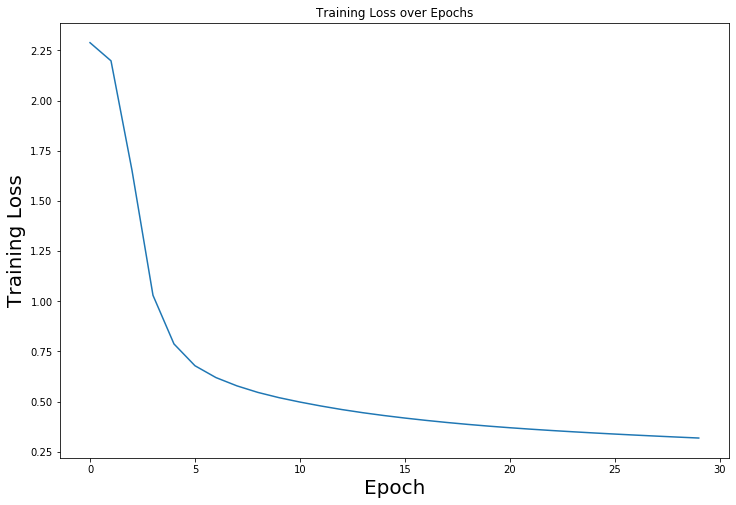

In [43]:
mlp, mlp_losses = train_network()

Now that our model is trained, we can test it. We're going to be looking at a classification matrix, with special emphasis on the accuracy:

In [44]:
def net_eval(net, test_loader): 
    net.eval()
    preds = []
    true_ys = []
    for Xs, ys in test_loader:
        outputs = net(Xs)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.tolist())
        true_ys.extend(ys.tolist())
        
    return preds, true_ys

Confusion matrix for our MLP classifier


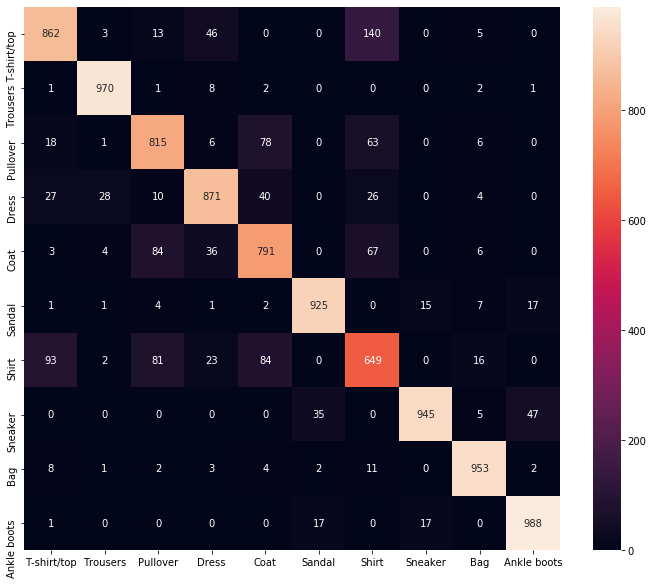

In [45]:
test_loader = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=128, shuffle=False)

preds, true_ys = net_eval(mlp, test_loader)
print("Confusion matrix for our MLP classifier") 
draw_cm(preds, true_ys)

Our MLP classifier visibly outperforms our K-Means algorithm. Most test images are classified correctly. We find that some T-shirts are misclassified as shirts, and that other shirt-shaped images are misclassified with each other. Below, we get precise values: 

In [46]:
print(classification_report(preds, true_ys))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1069
           1       0.96      0.98      0.97       985
           2       0.81      0.83      0.82       987
           3       0.88      0.87      0.87      1006
           4       0.79      0.80      0.79       991
           5       0.94      0.95      0.95       973
           6       0.68      0.68      0.68       948
           7       0.97      0.92      0.94      1032
           8       0.95      0.97      0.96       986
           9       0.94      0.97      0.95      1023

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



We get an overall precision of 0.88 which is good. The worse f1 score happens on coats at 0.8. A lot of the coats are classified as other shirt-shaped clothes or dresses. Trousers come out on top again with an f1 score of 0.97. Overall, we find the worse precisions on everything shirt-shaped.


### 2.2.2 Convolutional neural network (CNN) supervised classification
In the previous task we worked with a vanilla MLP. We're now going to try using a Convolutional Neural Network, and compare our results.

Our CNN is to have the following architecture:
![222archi](222archi.png)

As told, here are our parameters:
* Activation function: ReLU
* Stride into pooling layers: 2
* Pick the max subsampled feature map
* Kernel size: 5
* stride and dilation in conv. layers: 1
* Other parameters equal to tasks 2.2.1

This task follows the order of 2.2.1's. We'll create our CNN class, train it, and analyze the results. This time, we'll be feeding in matrices of dimensions 28x28 so we need to reshape our vectors.

In [47]:
train_tensor_CNN = TensorDataset(torch.tensor(X_train_scaled.reshape(60000, 1, 28, 28)), torch.tensor(y_train))
test_tensor_CNN = TensorDataset(torch.tensor(X_test_scaled.reshape(10000, 1, 28, 28)), torch.tensor(y_test))

In [48]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, dilation=1)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, dilation=1)
        self.c5 = nn.Linear(in_features=256, out_features=120)
        self.f6 = nn.Linear(in_features=120, out_features=84)
        self.out = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, input):
        #C1 and S2
        out = F.relu(self.c1(input))
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        
        #C3 and S4
        out = F.relu(self.c3(out))
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        
        #C5 and F6
        out = out.reshape(-1, 256)
        out = F.relu(self.c5(out))
        out = F.relu(self.f6(out))
        
        #LogSoftmax for NLLLoss
        out = self.out(out)
        out = nn.LogSoftmax(dim=1)(out)
        
        return out

In [49]:
cnn, cnn_losses = train_network(network=CNN(), train_tensor=train_tensor_CNN, graph=False)

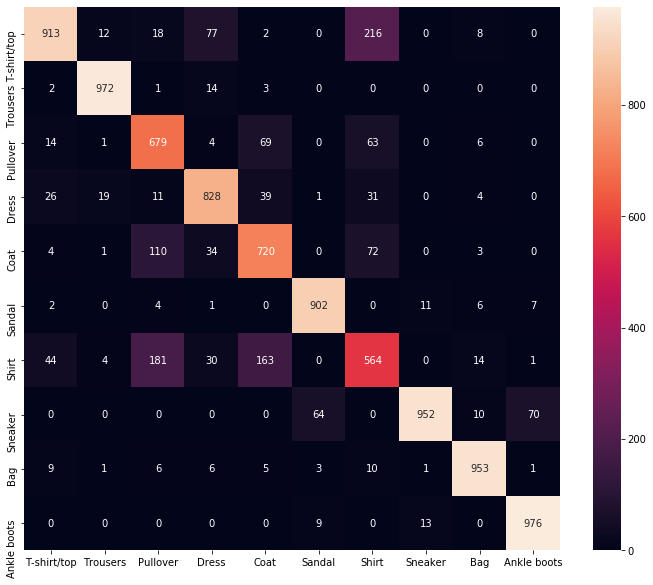

In [50]:
test_loader_CNN = torch.utils.data.DataLoader(dataset=test_tensor_CNN, batch_size=128, shuffle=False)

preds_CNN, true_ys_CNN = net_eval(cnn, test_loader_CNN)
draw_cm(preds_CNN, true_ys_CNN)

Our CNN classifier does well but not as well as our MLP. We encounter the problem again where shirt-shaped things are sometimes confused for each other. The other classes are well classified.

In [51]:
print(classification_report(preds_CNN, true_ys_CNN))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1246
           1       0.96      0.98      0.97       992
           2       0.67      0.81      0.74       836
           3       0.83      0.86      0.85       959
           4       0.72      0.76      0.74       944
           5       0.92      0.97      0.94       933
           6       0.59      0.56      0.58      1001
           7       0.97      0.87      0.92      1096
           8       0.95      0.96      0.95       995
           9       0.93      0.98      0.95       998

    accuracy                           0.85     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.85      0.85      0.85     10000



Concretely, we get an average of 0.85, which is slightly below our MLP's (0.88). We'll compare and explain in the next section.

Every class that isn't shirt-shaped has f1 scores above 0.90 but the shirts struggle. This makes sense as CNNs can identify features (like sleeves, for example) and if multiple classes have them then that could lead to confusion.

### 2.2.3 Comparisons of the classifiers

Overall, we found that the two classifiers performed well. MLP had a better accuracy than the CNN classifier by 2%. 

This is interesting because CNNs are known to be much better at classifying images than MLPs. This is because MLPs disregard the spatial properties of an image by flattening it into a one-dimensional vector. By doing this, you lose information and the relations between neighbouring pixels. The idea behind CNNs is that you will account for local connectivity (filters are panned around the image to find and match patterns, no matter where) and this will allow the classifier to learn about "features" of the image.

Considering that CNNs are known to be very good at object recognition, how is it that the MLP outperformed the CNN? Below, we'll answer that, and show that our CNN can easily be hyper-parameter tuned to do much better.

#### Number of Parameters
First of all, we'll compare the number of parameters in the MLP and CNN classifiers. A parameter can either be the weight of a neuron, or the biases included at every layer. As such, we have to iterate over every layer of our net and count the biases and weights. Luckily, pytorch does that for us:

In [52]:
mlp_params = np.sum([p.numel() for p in mlp.parameters()])
print(f"Number of parameters in the MLP classifier {mlp_params}")
cnn_params = np.sum([p.numel() for p in cnn.parameters()])
print(f"Number of parameters in the CNN classifier {cnn_params}")

Number of parameters in the MLP classifier 109810
Number of parameters in the CNN classifier 44426


This gives us insight as to why the MLP could have outperformed the CNN: the MLP has over double the parameters of the CNN. This result shows that our CNN, with half the size of the MLP, achieves nearly the same results as the MLP.

In fact, MLPs are very dense because all the layers are fully connected. This creates really dense networks and make training really expensive. On the other hand, CNNs have smaller weights, and fewer of them because layers are sparsely connected. This leads to efficiency and potentially allows us to create deeper networks. When we hyper-parameter tune our CNN, we'll see we can get them to perform really well.

#### Comparing Unsupervised and Supervised Techniques
Both our neural nets blew the KMeans algorithm out of the water. We got an accuracy of 48% on the KMeans, while both our nets are over 80%. This task wasn't suited to our clustering K-Means because we had really high dimensions. The problem is that over hundreds of dimensions (784, in our case), the volume of our space increases too fast compared to the amount of points we've got in the dataset, meaning our data becomes very sparse and correctly classifying becomes harder. There are a few solutions to remediate to this. For example, we could change our distance metric. Nevertheles, as it is, KMeans struggles to make sense of the hundreds of dimensions whereas neural networks are better suited for these tasks.

In terms of the supervised techniques, we've already discussed that CNNs are better equipped to handle image recognition. Furthermore, the CNN achieved similar results to the MLP's with only half the parameters which is indicative that we could do much better.



#### CNN Tuning

My main concern when training the CNN in the earlier task was that 30 epochs wouldn't be enough for it to fully learn. From my research online, it seems like the Convolution layers are pretty standard and I wanted to study the effects of putting particular focus on the learning rates and number of training epochs. Below, we hyper-parameter tune our CNN with a selection of learning rates and epochs to get better accuracies on the MNIST fashion set.

In [60]:
from sklearn.model_selection import StratifiedKFold

def tune():

    lrs = [0.001, 0.005, 0.01, 0.05, 0.1]
    num_epochs = [30, 50, 75, 100]
    best_acc = 0
    params = {}

    for lr, epochs in zip(lrs, num_epochs) :
        avg_acc = 0
        cv = StratifiedKFold(n_splits=5)
        for training, test in cv.split(X_train_scaled, y_train):
            training_x = X_train_scaled[training]
            training_y = y_train[training]
            
            test_x = X_train_scaled[test]
            test_y = y_train[test]

            train_tensor = TensorDataset(torch.tensor(X_train_scaled.reshape(60000, 1, 28, 28)), torch.tensor(y_train))
            test_tensor= TensorDataset(torch.tensor(X_test_scaled.reshape(10000, 1, 28, 28)), torch.tensor(y_test))
            
            cnn, cnn_losses = train_network(network=CNN(), 
                                            learning_rate = lr,
                                            num_epochs = epochs,
                                            train_tensor=train_tensor, graph=False)
            preds_CNN, true_ys_CNN = net_eval(cnn, test_loader_CNN)
            acc = np.sum(np.array(preds_CNN) == np.array(true_ys_CNN))/len(preds_CNN)
            avg_acc += acc
        avg_acc = avg_acc/5
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            params['lr'] = lr
            params['num_epochs'] = epochs
            losses = cnn_losses
            net = cnn

    print(f"Our best accuracy for a tuned CNN was {best_acc:.3f}")
    return net, losses, params
    
_, tuned_losses, params = tune()

Our best accuracy for a tuned CNN was 0.904


It looks like our CNN made good use of an extra 20 epochs to train. We also doubled the learning rate and that seemed to have a positive effect. Since it didn't pick 75 as the optimal number of epochs, it must start overfitting somewhere between 50 and 75. Any learning rate above 0.01 must be too high and lead to problems converging.

In [61]:
print(params)

{'num_epochs': 50, 'lr': 0.01}


# 4
## 4.1 Comparing PCA and NMF dimensionality reduction
Both Principal Component Analysis (PCA), and Non-Negative Matrix Factorisation (NMF) are techniques for dimensionality reduction. Letting $V$ represent a matrix of dimension 784x60000 (every image in our dataset is a vertical vector), both PCA and NMF create approximate factorisations of $V = WH$ where $W$ is called our basis image and is where we extract our new components from, and each column of $H$ is an encoding for our images in terms of the new components.

In this task, we'll do both on the fashion dataset, and analyse what reduced dimensions represent in terms of the original images, and how they work.

Finally, since our problem with KMeans earlier on was that we had too many dimensions, we'll quickly try applying KMeans to the 10 components we've gotten from our PCA and NMF to see if we can increase our accuracy.

PCA and NMF work by feature extraction. What that means is that they create new variables by studying how our current features behave together and relate. The two algorithms do so differently.

### PCA

The idea of PCA is to reduce the dimensionality of our data by projecting it into smaller spaces, looking to create principal components (i.e. our "new features") that are orthogonal to each other, thus making them statistically independent from each other. The algorithm does that by picking our correlated features, turning them into new components, and transforming the data to a new coordinate system where the greatest variance lies on the first principal component, etc...

By design, the first principal component is the one with the maximised variance, and it decreases with every further component used.


We'll use $W$ and $H$ as described above. PCA forces the columns of $W$ to be orthonormal and the rows of $H$ to be orthogonal to each other. This means that every image in our dataset will be approximated by a linear combination of the basis images.

PCA is sensitive to the initial scaling of the data so we feed it our standardised data:

In [62]:
pca = PCA(n_components=10).fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

We then try to visualize the ten components created by the PCA algorithm. Nevertheless, PCA principal components allow negative values. This is because we're using correlation to capture information on multiple features in one. As such, we want to be able to capture the fact that some features are negatively correlated.

Because PCA allows negative entries in the components, we'll draw components where the negative values are in red.

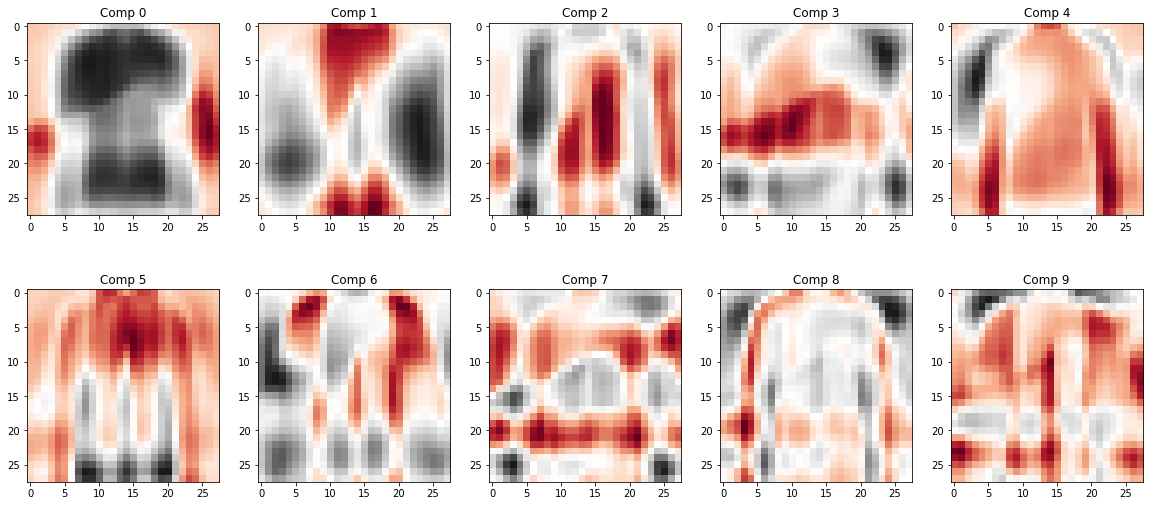

In [63]:
H = pca.components_

plt.figure(figsize=(20,9))

for i in range(10):
    comp = H[i]
    plt.subplot(2, 5, i+1)
    cmap = plt.cm.RdGy
    plt.title(f'Comp {i}')
    plt.imshow(comp.reshape(28, 28), cmap, interpolation='nearest')


It's hard to extract meaning from any of these components visually. As mentioned in the description of PCA above, this is because in PCA the components form a sort of basis for every image in our dataset. This leads to one component not meaning much. Only together do they form sensible images.

As mentioned above, every further component has a decreasing variance ratio (the variance of the component divided by the sum of the variances of all the components). This is because at every iteration the chosen principal component is the one with the largest variance (ie. the one that could do the most work in explaining features, and removing them). As such, if we picked as many principal components as we had features, we would have an explained variance of 1. For every component we forego, we lose a bit of information. On the graph below, we plot the cumulative sum of our principal components' explained variance:

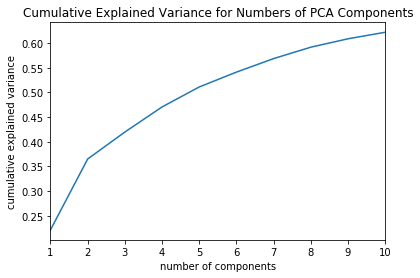

In [64]:
plt.plot(range(1,11), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance for Numbers of PCA Components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim((1,10))
plt.show()

We find that together our 10 principal components account for just above 0.6 of the explained variance meaning that we can describe our initial (28x28) dataset quite well with only 10 components.

To get an idea of what these components look like, even though they lack any visible meaning, we display a few of them. 

In [65]:
X_pca = pd.DataFrame(X_pca)
for i in range(10):
    X_pca = X_pca.rename(columns={i: f"Comp {i}"})
X_pca['label'] = y_train
X_pca.head()

,Comp 0,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Comp 7,Comp 8,Comp 9,label
0,-12.881243,-2.339886,4.296561,3.279208,-0.703484,3.198159,3.168637,1.286024,-1.731744,-0.637290,8
1,-18.165733,4.158204,0.718979,-8.092390,2.508011,1.269279,-1.446737,6.355762,2.334889,-2.396096,7
2,1.827621,2.206284,11.275218,1.112287,0.866802,-6.827107,-1.545543,3.174097,-4.690001,3.366504,2
3,-16.223248,3.335836,1.120078,-4.083227,0.373619,1.730069,-2.353708,-0.591173,-1.081118,1.645417,5
4,-21.385824,-1.442210,4.428689,-0.496780,0.582488,-0.231041,-2.069920,-0.501674,-0.295914,1.076497,5


To try and visually justify our deconstruction of images into Principal Components, we'll graph a scatter plot of all our images with the two principal components against each other and show that even with 2 components we can infer some groupings.

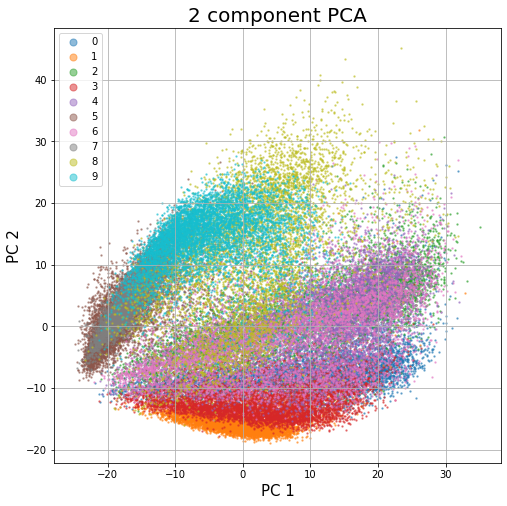

In [66]:
fig = plt.figure(figsize = (8,8))
plt.title('2 component PCA', fontsize = 20)

for label in set(y_train):
    labeled = X_pca[X_pca['label'] == label]
    plt.scatter(labeled['Comp 0'], labeled['Comp 1'], s=2, label=str(label), alpha=0.5)
    
plt.xlabel('PC 1', fontsize = 15)
plt.ylabel('PC 2', fontsize = 15)
plt.legend(markerscale=5)
plt.grid()

Every color represents a class in our dataset. With only the two first principal components, we can see that the labels are already grouped quite well. To make a distinction, we'll graph the two last principal components we have and show that they will have less clear groupings because of their smaller explained variance. 

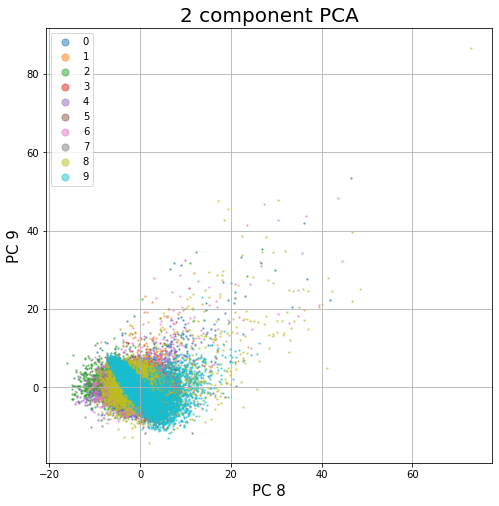

In [67]:
fig = plt.figure(figsize = (8,8))
plt.title('2 component PCA', fontsize = 20)

for label in set(y_train):
    labeled = X_pca[X_pca['label'] == label]
    plt.scatter(labeled['Comp 8'], labeled['Comp 9'], s=2, label=str(label), alpha=0.5)
    
plt.xlabel('PC 8', fontsize = 15)
plt.ylabel('PC 9', fontsize = 15)
plt.legend(markerscale=5)
plt.grid()

Notice here that all the labels overlap. This is because components 8 and 9 have a much smaller explained variance and thus don't distinguish the labels as well. We can also make sure that the 9 components are indeed completely uncorrelated.

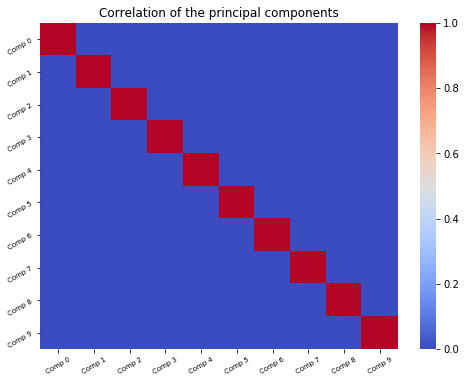

In [68]:
plt.figure(figsize=(8,6))

s=sbn.heatmap(X_pca.iloc[:,:-1].corr(),cmap='coolwarm') 
s.set_title("Correlation of the principal components")
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)

plt.show()

## NMF
Similarly to PCA, NMF also finds a factorisation of $V$ in the form $V = WH$. $H$ still represents the encoding of our images and $W$. The difference resides in what $W$ represents. Whereas in our PCA every entry of $W$ represents full images, in NMF we do feature-based learning and every column of $W$ highlights an important feature in objects. It is then theoretically possible to recompose all our images by mixing-and-matching these features into one. Furthermore, NMF differs from PCA as well in the sparsity of the components. Because PCA tries to represent a holistic image, the image has values all across it. On the other hand, NMF targets specific features in subsections of images which means the rest of the image often has pixels set to 0.

Another distinction is that NMF does not allow negative entries in $W$ and $H$. These constraints allow combinations of multiple basis images to represent an item of clothing and is part of the reason NMF is parts-based representations.

In other words, or NMF basis images show emphasis on features, and builds every image we have by combining features, whereas PCA basis images alone don't represent anything concrete but more a holistic view of our images.  

Because we need every entry to be positive, we normalize our data, and then ask for 10 features.

In [69]:
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

#Non negative inputs
nmf = NMF(n_components=10).fit(X_train_norm)
X_nmf = nmf.transform(X_train_norm)
X_test_nmf = nmf.transform(X_test_norm)

Let's take a look at our 10 components:

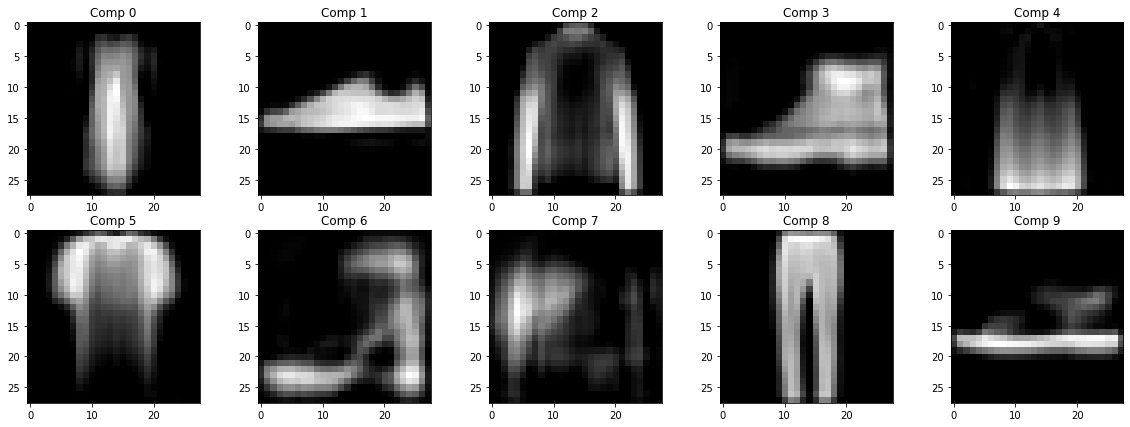

In [70]:
H = nmf.components_

plt.figure(figsize=(20,7))
for i in range(10):
    plt.subplot(2, 5, i+1);
    plt.title(f'Comp {i}')
    plt.imshow(H[i].reshape(28, 28),
                  cmap = plt.cm.gray, interpolation='nearest');


We can see that the algorithm worked as described. Every component seems to be the representation of a feature on specific items of clothing. For example, we can clearly recognize sleeves on Component 2, and short sleeves on Component 5. Pants have a very specific shape and are thus recognized as a feature in Component 8.

Because these components represent features and that every item is going to be a mix and match of features, we're going to find that some of these components are probably related. For example, you would expect the Tshirt images to have high values for Component 4, and Component 5. Let's find out if this is the case by plotting a heatmap of the correlations between the components.

In [71]:
X_nmf = pd.DataFrame(X_nmf)
for i in range(10):
    X_nmf = X_nmf.rename(columns={i: f"Comp {i}"})
X_nmf['label'] = y_train

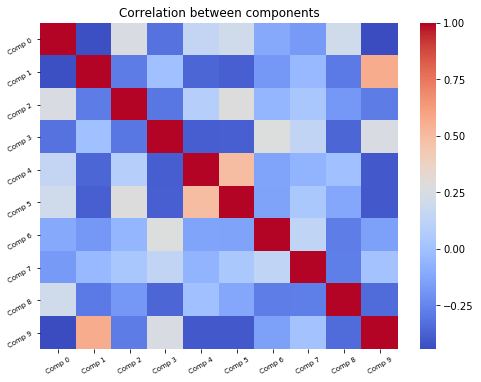

In [72]:
plt.figure(figsize=(8,6))

s=sbn.heatmap(X_nmf.iloc[:,:-1].corr(),cmap='coolwarm') 
s.set_title("Correlation between components")
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)

plt.show()

Firstly, notice that whereas PCA components were statistically independent from each other, NMF components have some correlations. We find that Components 4 and 5 are quite highly correlated, and so are 1 and 9. Both these make intuitive sense as Components 4 and 5 together give a decent representation of a tshirt, and 1 combined with 9 give the sole of a shoe, and the upper part of a sneaker, recreating a full sneaker.

We can also find some negative correlations for features that really don't match well.

### Using PCA and NMF to mitigate curse of dimensionality (aside)
As mentioned in 2.2.3 when comparing the unsupervised KMeans and the CNN and MLP, the KMean algorithm suffers from the curse of dimensionality. Now that we've found ways to reduce dimensionality, (NMF, and PCA), it would be interesting to see if we can get better results on our unsupervised KMeans using the ten components for both PCA and NMF.

Once again, we deal with the KMeans randomness by running it 10 times with different centroid initialisation seeds and keep the best. All of this happens under the hood when we set the parameter `n_init` to 10.

#### NMF

In [73]:
NMF_kmean = KMeans(n_clusters=10, n_init=10, n_jobs=-1)
X_nmf = X_nmf.drop("label", axis=1)
NMF_kmean.fit(X_nmf)

assignment = cluster_assignment(y_train, NMF_kmean.labels_)
predicted = NMF_kmean.predict(X_test_nmf)
predicted_labels = [assignment[pred][1] for pred in predicted]

print(classification_report(predicted_labels, y_test))

              precision    recall  f1-score   support

           0       0.86      0.50      0.63      1738
           1       0.84      0.99      0.91       860
           2       0.22      0.25      0.24       906
           3       0.77      0.70      0.73      1104
           4       0.71      0.36      0.48      1968
           5       0.40      0.49      0.44       791
           6       0.00      0.00      0.00       653
           7       0.50      0.79      0.61       615
           8       0.39      0.93      0.55       418
           9       0.57      0.63      0.60       947

    accuracy                           0.53     10000
   macro avg       0.53      0.56      0.52     10000
weighted avg       0.60      0.53      0.54     10000



#### PCA

In [74]:
PCA_kmean = KMeans(n_clusters=10, n_init=10, n_jobs=-1)
X_pca = X_pca.drop("label", axis=1)
PCA_kmean.fit(X_pca)

assignment = cluster_assignment(y_train, PCA_kmean.labels_)
predicted = PCA_kmean.predict(X_test_pca)
predicted_labels = [assignment[pred][1] for pred in predicted]

print(classification_report(predicted_labels, y_test))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55      1215
           1       0.91      0.59      0.72      1543
           2       0.00      0.01      0.00       387
           3       0.00      0.00      0.00       410
           4       0.59      0.38      0.46      1538
           5       0.63      0.48      0.55      1281
           6       0.36      0.27      0.31      1254
           7       0.80      0.70      0.75      1122
           8       0.39      0.92      0.55       427
           9       0.58      0.75      0.65       823

    accuracy                           0.49     10000
   macro avg       0.49      0.46      0.45     10000
weighted avg       0.58      0.49      0.52     10000



Our KMean algorithm outperforms the 2.2.1 classifier by 5% using the NMF feature-based approach, whereas the PCA decomposition adds no value in accuracy compared to our previous results. As we'd seen above, the PCA with 10 components only had 0.6 explained variance so it would be interesting to add a few more of the next components to see how that affects our accuracy.

## 4.2 Latent Dirichlet Allocation (LDA) applied to images
LDA is a type of topic modelling algorithm. It's often used in NLP to analyse collections of text documents and model topics. By imagining every image as a 'document' and every pixel as a 'word', we'll find out if we can apply an LDA algorithm to our fashion dataset to find 10 different 'topics' corresponding to the 10 types of clothes. 

LDA works by assuming how a document is written, and backtracking from a document, tries to find a set of topics that is likely to have generated the document. Here are the assumptions made:
* The number of words in a document follows a Poisson distribution
* From the fixed list of existing topics, a topic mixture is chosen (the distribution of topics through the text)
* Each word is then generated by picking a topic in the topic mixture, and then using the topic to generate a word within the topics.


In [75]:
lda = LatentDirichletAllocation(n_components=10).fit(X_train)
X_lda = lda.transform(X_train)

We're going to visualize the components and compare them to the ones in 4.1 and 2.1.

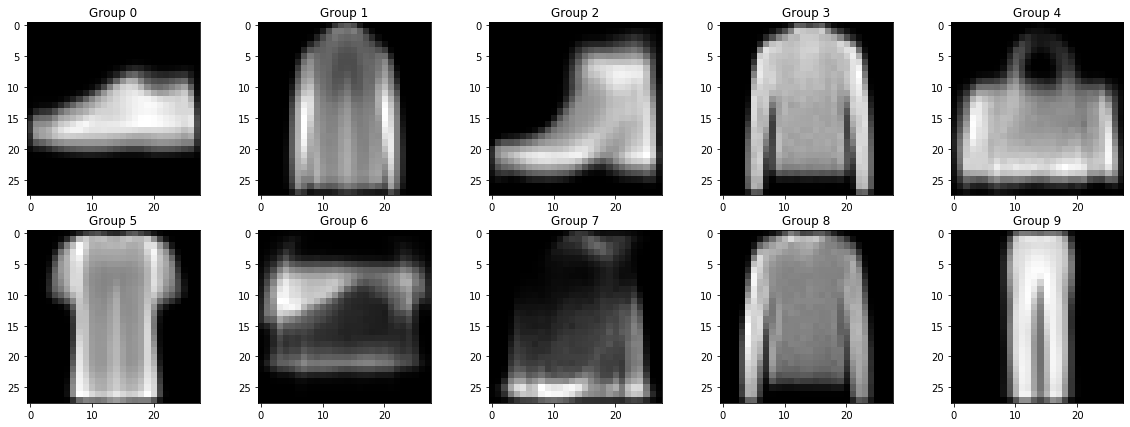

In [76]:
H = lda.components_

plt.figure(figsize=(20,7))
for i in range(10):
    plt.subplot(2, 5, i+1);
    plt.title(f'Group {i}')
    plt.imshow(H[i].reshape(28, 28),
                  cmap = plt.cm.gray, interpolation='nearest');

Although all these groups are all recognizable clothes, they're not well grouped. For instance, we're missing sandals, dresses, and the shirt-shapes are questionable.

I think this is because LDA is meant for topic recognition where every word is clearly assigned to one topic whereas in images the value of a pixel represents an value on a gradient from black to white. For example, a pixel with value 255 is nearly equivalent to a pixel with value 254. You'd never spot the difference and a good image classifier should probably be able to understand that. Nevertheless, with LDA, you completely dissociate the two values, calling them 2 different words, although they're super similar.

On top of that, LDA takes a flat array so it doesn't recognize features like a CNN does.

As such, I expect that the best classifier we could use for this task would be our convolution net. Next, a simple MLP. Finally, I think the LDA algorithm would probably fare worse than the KMeans because KMeans has a more intuitive measure of distance between pixels.